In [1]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import collections as coll

from glob import glob
from scipy import stats
from IPython.display import display
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score,confusion_matrix,jaccard_similarity_score

np.random.seed(20)

In [16]:
# Define function
def recalibratePred(predictions, factor):
    return predictions/(predictions+(1-predictions)/factor)

In [2]:
%%time
#Defining directory.
#Path = '/Users/olivierobalbinetti/Desktop/University College London/Term 2'\
#       '/Multi Agents Artificial Intelligence/Courseworks/Group coursework/'\
#       'Data/Original'

Path = 'C://Datasets//Multiagent//rtb'

#Importing data.
Datasets = {}
os.chdir(Path)
for Filename in glob('*.csv'):
    Datasets[Filename[:-4].title()] = pd.read_csv(Filename, sep = ',')
    
#Defining variables.
Test = Datasets['Test']
Train = Datasets['Train']
Validation = Datasets['Validation']
Total_data = sum([len(Datasets[key]) for key in Datasets.keys()])

#Feature engineering: ad exchange.
Test['adexchange'] = Test['adexchange'].fillna('nan')
Train['adexchange'] = Train['adexchange'].fillna('nan')
Validation['adexchange'] = Validation['adexchange'].fillna('nan')

#Feature engineering: slot size.
Test['slotsize'] = Test['slotwidth'].astype('str') + '*' +\
                   Test['slotheight'].astype('str')
Train['slotsize'] = Train['slotwidth'].astype('str') + '*' +\
                    Train['slotheight'].astype('str')
Validation['slotsize'] = Validation['slotwidth'].astype('str') + '*' +\
                         Validation['slotheight'].astype('str')

#Feature engineering: browser user agent.
Temp = Train['useragent'].str.split('_', n=1, expand=True)
Train['OS'] = Temp[0]
Train['Browser'] = Temp[1]

Temp = Test['useragent'].str.split('_', n=1, expand=True)
Test['OS'] = Temp[0]
Test['Browser'] = Temp[1]

Temp = Validation['useragent'].str.split('_', n=1, expand=True)
Validation['OS'] = Temp[0]
Validation['Browser'] = Temp[1]

#Feature engineering: user tags.
Train['usertag'] = Train['usertag'].fillna('nan')                      #Train.
Train['usertag list'] = Train['usertag'].str.split(',').values
Temp = list(Train['usertag list'].values)
Tags = [item for sublist in Temp for item in sublist]

Dict = dict(coll.Counter(Tags).most_common())
Dict['nan'] = max(Dict.values())+1
Dict = dict(sorted(Dict.items(), key=lambda kv: kv[1], reverse=True))
Dict = dict(enumerate(Dict.keys()))

Dict = {value:key for key,value in Dict.items()}
Dict['nan'] = 'nan'
Train = Train.assign(mapped=[[Dict[k] for k in row if Dict.get(k)]
                             for row in Train['usertag list'].values])


Test['usertag'] = Test['usertag'].fillna('nan')                         #Test.
Test['usertag list'] = Test['usertag'].str.split(',').values
Temp = list(Test['usertag list'].values)
Tags = [item for sublist in Temp for item in sublist]

Dict = dict(coll.Counter(Tags).most_common())
Dict['nan'] = max(Dict.values())+1
Dict = dict(sorted(Dict.items(), key=lambda kv: kv[1], reverse=True))
Dict = dict(enumerate(Dict.keys()))

Dict = {value:key for key,value in Dict.items()}
Dict['nan'] = 'nan'
Test = Test.assign(mapped=[[Dict[k] for k in row if Dict.get(k)]
                           for row in Test['usertag list'].values])


Validation['usertag'] = Validation['usertag'].fillna('nan')       #Validation.
Validation['usertag list'] = Validation['usertag'].str.split(',').values
Temp = list(Validation['usertag list'].values)
Tags = [item for sublist in Temp for item in sublist]

Dict = dict(coll.Counter(Tags).most_common())
Dict['nan'] = max(Dict.values())+1
Dict = dict(sorted(Dict.items(), key=lambda kv: kv[1], reverse=True))
Dict = dict(enumerate(Dict.keys()))

Dict = {value:key for key,value in Dict.items()}
Dict['nan'] = 'nan'
Validation = Validation.assign(mapped=[[Dict[k] for k in row if Dict.get(k)]
                                       for row in Validation['usertag list'].values])

#Feature engineering: renaming.
Test = Test.rename(columns={'mapped':'tagcodes'})
Train = Train.rename(columns={'mapped':'tagcodes'})
Validation = Validation.rename(columns={'mapped':'tagcodes'})

Wall time: 1min 32s


In [3]:
#Random downsample for training before more feature engineering 
downsample_factor = 0.00075
not_clicked_idx = np.where(Train["click"] ==0)[0]
clicked_idx = np.where(Train["click"] ==1)[0]
print("Original ratio",len(clicked_idx),len(not_clicked_idx))
print("Downsample factor:",downsample_factor)
print("New factor", len(clicked_idx)/(len(not_clicked_idx)*downsample_factor))
not_clicked_down_idx = np.random.choice(not_clicked_idx,size=(int(len(not_clicked_idx)*downsample_factor)),replace=True)
idx_concat = np.concatenate((clicked_idx,not_clicked_down_idx))

Train_subset = Train.loc[idx_concat]
print(Train_subset.head(5))

Original ratio 1793 2429188
Downsample factor: 0.00075
New factor 0.9841423004998652
       click  weekday  hour                                     bidid  \
1104       1        1    19  f9178e5b1b562648a5f63d36e423b0f26cec812d   
4949       1        2    22  42c7568c0c07baa53e2ed2548d80fde568b1a4c1   
8878       1        5     0  a305108883429eb515cc1246bb91a1e64a537476   
9790       1        2    19  c22254a0bad8028de4a6cdf51f502f6cf109c610   
10000      1        2    17  e42e60785c6f03678e8bdc7f5b5e3c054b902ae5   

                                         userid       useragent            IP  \
1104   ca22bf856b6c720994a95302f5ce71e0d6d5d416      windows_ie    114.93.5.*   
4949   9ed92c2038dfbaaf3ec37a48155e8712777cb21d      windows_ie   116.5.161.*   
8878   efbec188a3a7684e898747dd6cbe1194c7d89319  android_safari  117.136.24.*   
9790   875ee65d08205ed37fd33b12de85cc86f1ae2aae  android_safari  119.22.194.*   
10000  4cadd1388b905c04c641106ee3568358b655d92b  windows_chrome  14.134

In [ ]:
%%time


#Random downsample for training before more feature engineering 
downsample_factor = 0.00075
not_clicked_idx = np.where(Train["click"] ==0)[0]
clicked_idx = np.where(Train["click"] ==1)[0]
print("Original ratio",len(clicked_idx),len(not_clicked_idx))
print("Downsample factor:",downsample_factor)
print("New factor", len(clicked_idx)/(len(not_clicked_idx)*downsample_factor))
not_clicked_down_idx = np.random.choice(not_clicked_idx,size=(int(len(not_clicked_idx)*downsample_factor)),replace=True)
idx_concat = np.concatenate((clicked_idx,not_clicked_down_idx))

Train_subset = Train.loc[idx_concat]
print(Train_subset.head(5))
weekday_dummies = pd.get_dummies(Train_subset['weekday']).rename(columns=lambda x:'Weekday_' + str(x))
#tag_dummies = pd.get_dummies(Train['tagcodes'])
Train_subset = pd.concat([Train_subset,weekday_dummies], axis=1)
weekday_dummies = pd.get_dummies(Validation['weekday']).rename(columns=lambda x:'Weekday_' + str(x))
Validation = pd.concat([Validation,weekday_dummies], axis=1)
weekday_dummies = pd.get_dummies(Test['weekday']).rename(columns=lambda x:'Weekday_' + str(x))
Test = pd.concat([Test,weekday_dummies], axis=1)


#User tag columns for Train & Validation
usertag_dummies = Train_subset['usertag list'].str.join('|').str.get_dummies().add_prefix('tags_')
usertag_dummies.drop(columns=['tags_nan'], inplace=True)
Train_subset = pd.concat([Train_subset,usertag_dummies], axis=1)

usertag_dummies = Validation['usertag list'].str.join('|').str.get_dummies().add_prefix('tags_')
usertag_dummies.drop(columns=['tags_nan'], inplace=True)
Validation = pd.concat([Validation,usertag_dummies], axis=1)

usertag_dummies = Test['usertag list'].str.join('|').str.get_dummies().add_prefix('tags_')
usertag_dummies.drop(columns=['tags_nan'], inplace=True)
Test = pd.concat([Test,usertag_dummies], axis=1)

In [5]:
%%time
# Change categorical string variables to int
# Error in columns: adexchange, domain, slotid, slotvisibility, slotformat, creative, keypage, OS, Browser

Train_subset['OS_enc']  = Train_subset['OS']  
Train_subset['Browser_enc'] = Train_subset['Browser']
Validation['OS_enc']  = Validation['OS']  
Validation['Browser_enc'] = Validation['Browser']
Test['OS_enc']  = Test['OS']  
Test['Browser_enc'] = Test['Browser']

labels_os = Train['OS'].astype('category').cat.categories.tolist()
labels_browser = Train['Browser'].astype('category').cat.categories.tolist()
label_os_enc = {'OS_enc' : {k: v for k,v in zip(labels_os,list(range(1,len(labels_os)+1)))}}
label_brow_enc = {'Browser_enc' : {k:v for k,v in zip(labels_browser,list(range(1,len(labels_browser)+1)))}}
Train_subset.replace(label_brow_enc, inplace=True)
Train_subset.replace(label_os_enc, inplace=True)
Validation.replace(label_brow_enc, inplace=True)
Validation.replace(label_os_enc, inplace=True)
Test.replace(label_brow_enc, inplace=True)
Test.replace(label_os_enc, inplace=True)


Wall time: 4.09 s


In [6]:
#Train_subset.columns.intersection(Validation.columns)
#Train_subset.columns.values


In [7]:
%%time

# Different sets of manually selected features

selected_features = [['hour', 'region', 'city', 'adexchange', 'domain',  \
                 'urlid', 'slotid', 'slotwidth', 'slotheight', 'slotvisibility', 'slotformat', 'slotprice', 'creative', 'bidprice', \
                 'payprice', 'keypage', 'advertiser', 'OS', 'Browser', 'Weekday_0',\
                 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'tags_10006', 'tags_10024', 'tags_10031',\
                 'tags_10048', 'tags_10052', 'tags_10057', 'tags_10059', 'tags_10063', 'tags_10067', 'tags_10074', 'tags_10075', \
                 'tags_10076', 'tags_10077', 'tags_10079', 'tags_10083', 'tags_10093', 'tags_10102', 'tags_10110', 'tags_10111', \
                 'tags_10114', 'tags_10115', 'tags_10116', 'tags_10117', 'tags_10118', 'tags_10120', 'tags_10123', 'tags_10125', \
                 'tags_10126', 'tags_10127', 'tags_10129', 'tags_10130', 'tags_10131', 'tags_10133', 'tags_10138', 'tags_10140', \
                 'tags_10142', 'tags_10145', 'tags_10146', 'tags_10147', 'tags_10148', 'tags_10149', 'tags_10684', 'tags_11092', \
                 'tags_11278', 'tags_11379', 'tags_11423', 'tags_11512', 'tags_11576', 'tags_11632', 'tags_11680', 'tags_11724', \
                 'tags_11944', 'tags_13042', 'tags_13403', 'tags_13496', 'tags_13678', 'tags_13776', 'tags_13800', 'tags_13866', \
                 'tags_13874', 'tags_14273', 'tags_15398', 'tags_16593', 'tags_16617', 'tags_16661', 'tags_16706', 'tags_16751', \
                 'tags_16753'],
                     ['hour', 'region', 'city',  \
                 'urlid', 'slotwidth', 'slotheight', 'slotprice', 'bidprice', \
                 'payprice','advertiser', 'Weekday_0',\
                 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'tags_10006', 'tags_10024', 'tags_10031',\
                 'tags_10048', 'tags_10052', 'tags_10057', 'tags_10059', 'tags_10063', 'tags_10067', 'tags_10074', 'tags_10075', \
                 'tags_10076', 'tags_10077', 'tags_10079', 'tags_10083', 'tags_10093', 'tags_10102', 'tags_10110', 'tags_10111', \
                 'tags_10114', 'tags_10115', 'tags_10116', 'tags_10117', 'tags_10118', 'tags_10120', 'tags_10123', 'tags_10125', \
                 'tags_10126', 'tags_10127', 'tags_10129', 'tags_10130', 'tags_10131', 'tags_10133', 'tags_10138', 'tags_10140', \
                 'tags_10142', 'tags_10145', 'tags_10146', 'tags_10147', 'tags_10148', 'tags_10149', 'tags_10684', 'tags_11092', \
                 'tags_11278', 'tags_11379', 'tags_11423', 'tags_11512', 'tags_11576', 'tags_11632', 'tags_11680', 'tags_11724', \
                 'tags_11944', 'tags_13042', 'tags_13403', 'tags_13496', 'tags_13678', 'tags_13776', 'tags_13800', 'tags_13866', \
                 'tags_13874', 'tags_14273', 'tags_15398', 'tags_16593', 'tags_16617', 'tags_16661', 'tags_16706', 'tags_16751', \
                 'tags_16753'],
                     ['hour', 'region', 'city',  \
                 'urlid', 'slotwidth', 'slotheight', 'slotprice', 'bidprice', \
                 'payprice','advertiser', 'Weekday_0',\
                 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'OS', 'Browser',    'tags_10006', 'tags_10024', 'tags_10031',\
                 'tags_10048', 'tags_10052', 'tags_10057', 'tags_10059', 'tags_10063', 'tags_10067', 'tags_10074', 'tags_10075', \
                 'tags_10076', 'tags_10077', 'tags_10079', 'tags_10083', 'tags_10093', 'tags_10102', 'tags_10110', 'tags_10111', \
                 'tags_10114', 'tags_10115', 'tags_10116', 'tags_10117', 'tags_10118', 'tags_10120', 'tags_10123', 'tags_10125', \
                 'tags_10126', 'tags_10127', 'tags_10129', 'tags_10130', 'tags_10131', 'tags_10133', 'tags_10138', 'tags_10140', \
                 'tags_10142', 'tags_10145', 'tags_10146', 'tags_10147', 'tags_10148', 'tags_10149', 'tags_10684', 'tags_11092', \
                 'tags_11278', 'tags_11379', 'tags_11423', 'tags_11512', 'tags_11576', 'tags_11632', 'tags_11680', 'tags_11724', \
                 'tags_11944', 'tags_13042', 'tags_13403', 'tags_13496', 'tags_13678', 'tags_13776', 'tags_13800', 'tags_13866', \
                 'tags_13874', 'tags_14273', 'tags_15398', 'tags_16593', 'tags_16617', 'tags_16661', 'tags_16706', 'tags_16751', \
                 'tags_16753'],
                     ['hour', 'region', 'city',  \
                 'urlid', 'slotwidth', 'slotheight', 'slotprice', 'bidprice', \
                 'payprice','advertiser', 'Weekday_0',\
                 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'OS_enc', 'Browser_enc'],
                     ['hour', 'region', 'city',  \
                 'urlid', 'slotwidth', 'slotheight', 'slotprice', 'bidprice', \
                 'payprice','advertiser', 'Weekday_0',\
                 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'OS_enc', 'Browser_enc',  'tags_10006', 'tags_10024', 'tags_10031',\
                 'tags_10048', 'tags_10052', 'tags_10057', 'tags_10059', 'tags_10063', 'tags_10067', 'tags_10074', 'tags_10075', \
                 'tags_10076', 'tags_10077', 'tags_10079', 'tags_10083', 'tags_10093', 'tags_10102', 'tags_10110', 'tags_10111', \
                 'tags_10114', 'tags_10115', 'tags_10116', 'tags_10117',  'tags_10120', 'tags_10123', 'tags_10125', \
                 'tags_10126', 'tags_10127', 'tags_10129',  'tags_10131', 'tags_10133', 'tags_10138', 'tags_10140', \
                 'tags_10142', 'tags_10145', 'tags_10146', 'tags_10147', 'tags_10148', 'tags_10149', 'tags_10684', 'tags_11092', \
                 'tags_11278', 'tags_11379', 'tags_11423', 'tags_11512', 'tags_11576', 'tags_11632', 'tags_11680', 'tags_11724', \
                 'tags_11944', 'tags_13042', 'tags_13403', 'tags_13496', 'tags_13678', 'tags_13776', 'tags_13800', 'tags_13866', \
                 'tags_13874', 'tags_14273',  'tags_16593', 'tags_16617', 'tags_16661', 'tags_16706', 'tags_16751', \
                 'tags_16753'],
                     ['hour', 'region', 'city',  \
                 'urlid', 'slotwidth', 'slotheight', \
                 'advertiser', 'Weekday_0',\
                 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'OS_enc', 'Browser_enc',  'tags_10006', 'tags_10024', 'tags_10031',\
                 'tags_10048', 'tags_10052', 'tags_10057', 'tags_10059', 'tags_10063', 'tags_10067', 'tags_10074', 'tags_10075', \
                 'tags_10076', 'tags_10077', 'tags_10079', 'tags_10083', 'tags_10093', 'tags_10102', 'tags_10110', 'tags_10111', \
                 'tags_10114', 'tags_10115', 'tags_10116', 'tags_10117',  'tags_10120', 'tags_10123', 'tags_10125', \
                 'tags_10126', 'tags_10127', 'tags_10129',  'tags_10131', 'tags_10133', 'tags_10138', 'tags_10140', \
                 'tags_10142', 'tags_10145', 'tags_10146', 'tags_10147', 'tags_10148', 'tags_10149', 'tags_10684', 'tags_11092', \
                 'tags_11278', 'tags_11379', 'tags_11423', 'tags_11512', 'tags_11576', 'tags_11632', 'tags_11680', 'tags_11724', \
                 'tags_11944', 'tags_13042', 'tags_13403', 'tags_13496', 'tags_13678', 'tags_13776', 'tags_13800', 'tags_13866', \
                 'tags_13874', 'tags_14273',  'tags_16593', 'tags_16617', 'tags_16661', 'tags_16706', 'tags_16751', \
                 'tags_16753']
                    ]

feat_sel = 5

#Get train and validation subsets

x_train = Train_subset[selected_features[feat_sel]]
y_train = Train_subset["click"]
#y_train

x_val = Validation[selected_features[feat_sel]]
y_val = Validation["click"]

x_test = Test[selected_features[feat_sel]]


Wall time: 878 ms


In [18]:
%%time
d_train = lgb.Dataset(x_train, label=y_train)
params = {} # LightGBM parameters
params['learning_rate'] = 0.05
params['boosting_type'] = 'dart'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 60
params['min_data'] = 50
params['max_depth'] = 5
params['min_data_in_leaf'] = 50
params['drop_rate'] = 0.9
clf = lgb.train(params, d_train, 100)

#Prediction
y_pred_val=clf.predict(x_val)


Wall time: 2.97 s


In [19]:
#ROC AUC score and confusion matrix

#Turn prediction into binary values
y_pred_bin = np.zeros(len(y_pred_val))
for i in range(len(y_pred_val)):
    if y_pred_val[i]>=.55:       # setting threshold to .5
        y_pred_bin[i]=1
    else:  
        y_pred_bin[i]=0

print("ROC AUC score", roc_auc_score(y_val,y_pred_bin))
print("Confusion Matrix\n", confusion_matrix(y_val, y_pred_bin))
#print((len(y_test[y_test==1]) - len(y_pred_bin[y_pred_bin==1])))

ROC AUC score 0.7741517780841408
Confusion Matrix
 [[282308  21415]
 [    77    125]]


 For reference
- params['learning_rate'] = 0.05
- params['boosting_type'] = 'dart'
- params['objective'] = 'binary'
- params['metric'] = 'binary_logloss'
- params['sub_feature'] = 0.5
- params['num_leaves'] = 10
- params['min_data'] = 50
- params['max_depth'] = 5
- clf = lgb.train(params, d_train, 100)

ROC 0.792

In [20]:
# Get pCTRs for Validation and Test Dataset
Path = 'C://Datasets//Multiagent//calc'
os.chdir(Path)

y_pred_test=clf.predict(x_test)
#print(len(y_real[y_real<0.5]))

# Recalibrate predictions
y_pred_test_recal = recalibratePred(y_pred_test,downsample_factor)
y_pred_val_recal =  recalibratePred(y_pred_val, downsample_factor)

# Write Test pCTR
Filename = 'LGBM_pCTR_test' + '.csv'
Header = 'bidid,pCTR'
with open(Filename, 'w') as file:
    file.write(Header + '\n')
    for request in range(0, len(Test)):
        file.write(Test['bidid'].iloc[request] + ',' + 
                   str(y_pred_test_recal[request]) + '\n')

# Write validation pCTR 
Filename = 'LGBM_pCTR_validation' + '.csv'
Header = 'bidid,pCTR'
with open(Filename, 'w') as file:
    file.write(Header + '\n')
    for request in range(0, len(Validation)):
        file.write(Validation['bidid'].iloc[request] + ',' + 
                   str(y_pred_val_recal[request]) + '\n')

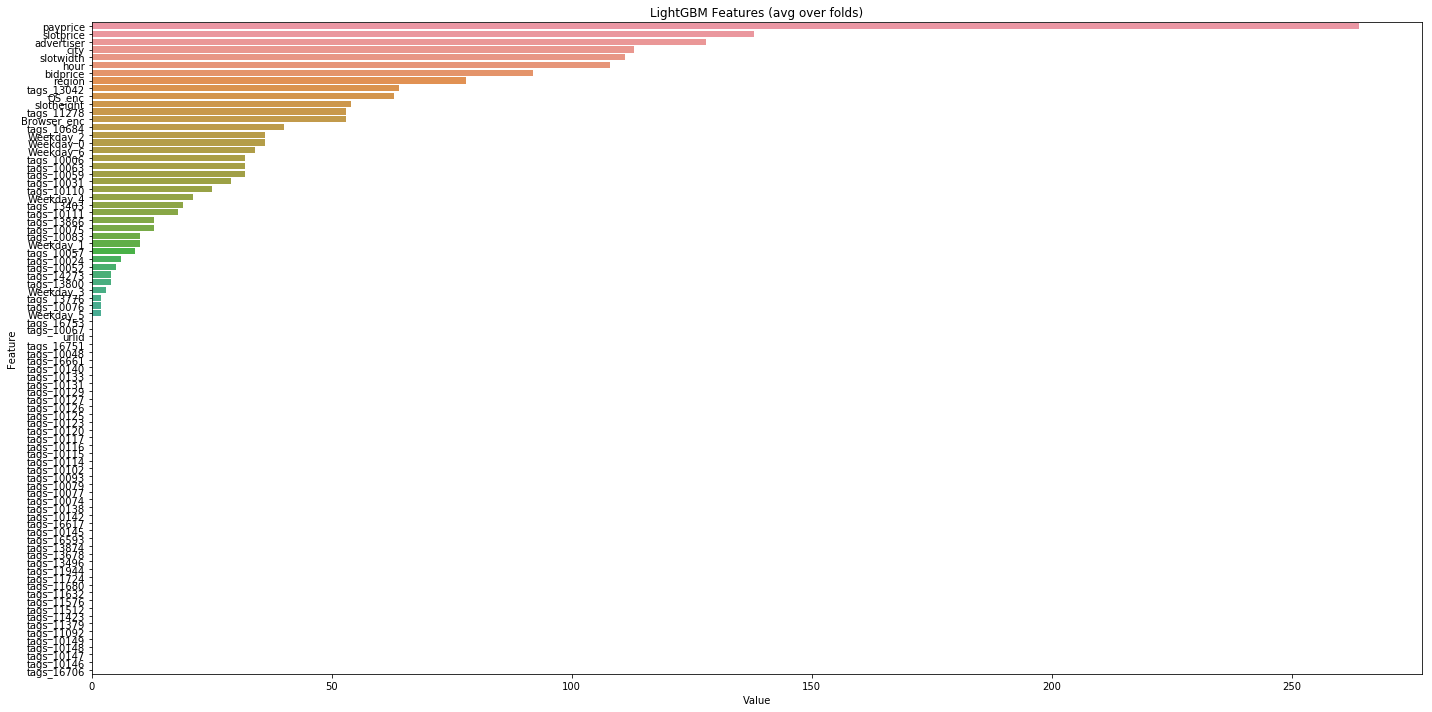

In [288]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances-01.png')